In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import hmp
from pathlib import Path
import os
import xarray as xr
from tqdm.notebook import tqdm
import mne
from mne.preprocessing import find_bad_channels_lof, ICA
from autoreject import AutoReject
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
data_prp1 = xr.load_dataset(DATA_PATH / "prp" / "data_t1_200hz_baseline.nc")

In [3]:
data_prp2 = xr.load_dataset(DATA_PATH / "prp2" / "data_t1_250hz.nc")

In [15]:
# Examine the structure and basic info about both datasets
print("=== Dataset 1 (prp1) ===")
print(f"Shape: {data_prp1.data.shape}")
print(f"Dimensions: {data_prp1.dims}")
print(f"Coordinates: {list(data_prp1.coords.keys())}")
print(f"Sampling rate: {data_prp1.attrs.get('sfreq', 'Not specified')} Hz")

print("\n=== Dataset 2 (prp2) ===")
print(f"Shape: {data_prp2.data.shape}")
print(f"Dimensions: {data_prp2.dims}")
print(f"Coordinates: {list(data_prp2.coords.keys())}")
print(f"Sampling rate: {data_prp2.attrs.get('sfreq', 'Not specified')} Hz")

# Check value ranges
print("\n=== Value Ranges ===")
print(f"PRP1 - Min: {data_prp1.data.min().values:.6f}, Max: {data_prp1.data.max().values:.6f}")
print(f"PRP1 - Mean: {data_prp1.data.mean().values:.6f}, Std: {data_prp1.data.std().values:.6f}")

print(f"PRP2 - Min: {data_prp2.data.min().values:.6f}, Max: {data_prp2.data.max().values:.6f}")
print(f"PRP2 - Mean: {data_prp2.data.mean().values:.6f}, Std: {data_prp2.data.std().values:.6f}")

=== Dataset 1 (prp1) ===
Shape: (21, 1280, 64, 448)
Dimensions: FrozenMappingWarningOnValuesAccess({'participant': 21, 'epoch': 1280, 'channel': 64, 'sample': 448})
Coordinates: ['epoch', 'channel', 'sample', 'rt', 'condition', 'trial_index', 'interval', 'correct', 'participant']
Sampling rate: 200.0 Hz

=== Dataset 2 (prp2) ===
Shape: (24, 960, 60, 611)
Dimensions: FrozenMappingWarningOnValuesAccess({'participant': 24, 'epochs': 960, 'channels': 60, 'samples': 611})
Coordinates: ['epochs', 'channels', 'samples', 'ex_akt', 'VP', 'Item', 'Wort', 'Ton', 'RT1', 'RT1korr', 'TonCode', 'ERR_ton', 'SOA', 'LEX', 'Bedingung', 'WortNr', 'WortRT', 'WortRTkorr', 'WortCode', 'OK', 'ERROR', 'SF', 'orth_N', 'Mean(WortRTkorr)', '2devRTWortkorr', 'ex', 'participant']
Sampling rate: 250.0 Hz

=== Value Ranges ===
PRP1 - Min: -0.000100, Max: 0.000100
PRP1 - Mean: -0.000000, Std: 0.000007
PRP2 - Min: -0.000100, Max: 0.000100
PRP2 - Mean: 0.000000, Std: 0.000008


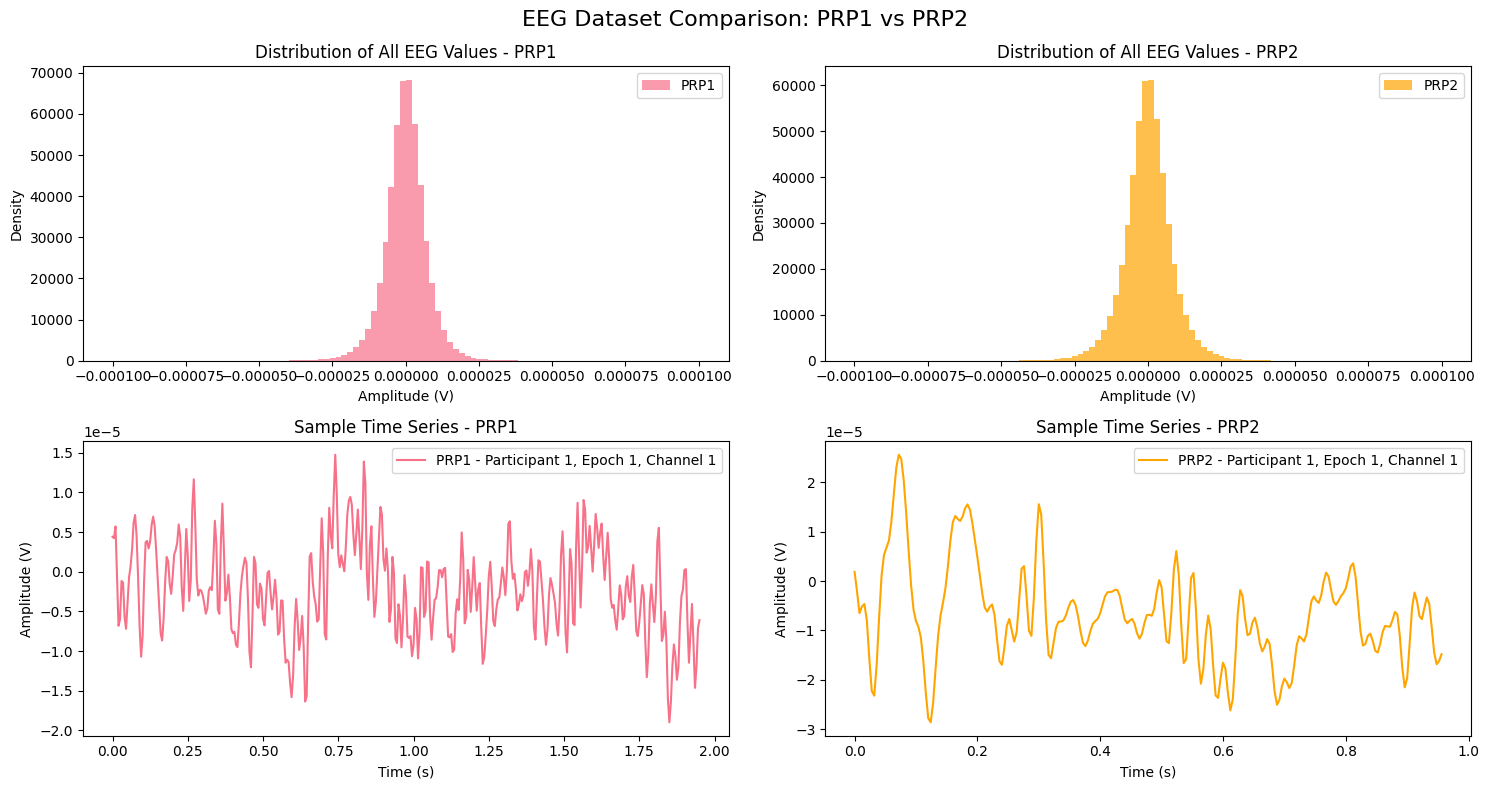

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('EEG Dataset Comparison: PRP1 vs PRP2', fontsize=16)

# 1. Histograms of all values
axes[0, 0].hist(data_prp1.data.values.flatten(), bins=100, alpha=0.7, label='PRP1', density=True)
axes[0, 0].set_title('Distribution of All EEG Values - PRP1')
axes[0, 0].set_xlabel('Amplitude (V)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

axes[0, 1].hist(data_prp2.data.values.flatten(), bins=100, alpha=0.7, label='PRP2', density=True, color='orange')
axes[0, 1].set_title('Distribution of All EEG Values - PRP2')
axes[0, 1].set_xlabel('Amplitude (V)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# 2. Sample time series from first participant, first epoch, first channel
time1 = np.arange(data_prp1.data.shape[-1]) / 200.0  # Convert samples to time (200 Hz)
time2 = np.arange(data_prp2.data.shape[-1]) / 250.0  # Convert samples to time (250 Hz)

axes[1, 0].plot(time1, data_prp1.data[0, 0, 0, :], label='PRP1 - Participant 1, Epoch 1, Channel 1')
axes[1, 0].set_title('Sample Time Series - PRP1')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude (V)')
axes[1, 0].legend()

axes[1, 1].plot(time2, data_prp2.data[0, 1, 0, :], label='PRP2 - Participant 1, Epoch 1, Channel 1', color='orange')
axes[1, 1].set_title('Sample Time Series - PRP2')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Amplitude (V)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()